This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [3]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7808a0116950>)

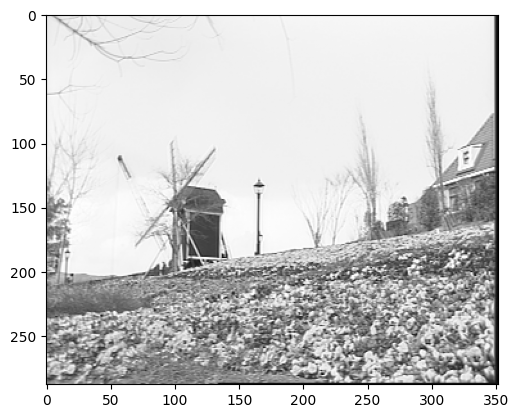

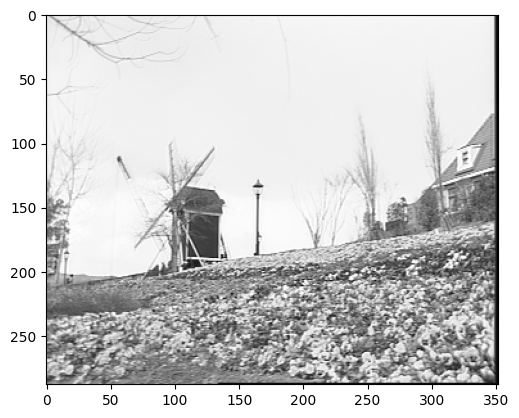

In [4]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [5]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [56]:
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """


    step = 8
    cont = 4*step

    REF = gaussian_filter(ref,1.)
    CUR = gaussian_filter(cur,1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV=np.zeros(2)

    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC


    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)

    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]

    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]

    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]

        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]

        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)

    pV = pV.ravel()

    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect

    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    # Non-regularized search
    if lamb == 0.:
        for r in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow,c:c+brow] # Block

                # Initialization:

                costMin = np.inf

                Rbest = np.zeros(B.shape)

                # Loop on candidate displacement vectors
                for dcol in range(c-search,c+search): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search,r+search): # rcol = candidate displacement vector over the rows
                        Bref = ref_extended[drow + search:drow + brow + search,dcol + search:dcol + bcol + search]
                        SSD_cost = np.sum((B - Bref)**2)
                        if SSD_cost  < costMin: # Save the results if they are better than the previous ones
                            Rbest = Bref
                            best_drow, best_dcol = drow, dcol
                            costMin = SSD_cost

                mvf[r:r+brow, c:c+bcol, 0] = r - best_drow # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 1] = c - best_dcol # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest

    else: # Regularized search
        for r in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol]# Block

                # Initializations
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)

                # Loop on candidate vectors
                for dcol in range(c-search,c+search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search, r+search+1): # rcol = candidate displacement vector over the rows
                        Bref = ref_extended[drow + search : drow + brow + search,dcol + search : dcol + bcol + search]
                        cost = (np.linalg.norm(B - Bref) ** 2 + lamb * np.linalg.norm(np.array([drow, dcol]) - pV) ** 2) # here, encore the REGULARIZED cost function
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = Bref
                            best_drow = drow
                            best_dcol = dcol


                mvf[r:r+brow,c:c+bcol,0]= r - best_drow # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= c - best_dcol # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest


    mvf = -mvf # For compatibility with standards

    return mvf, prediction



In [57]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

In [77]:
def displayMVF(I,mvf,subsamp):

    row,col = np.shape(I)

    # Subsample dense MVF
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]

    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)

    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)


    return

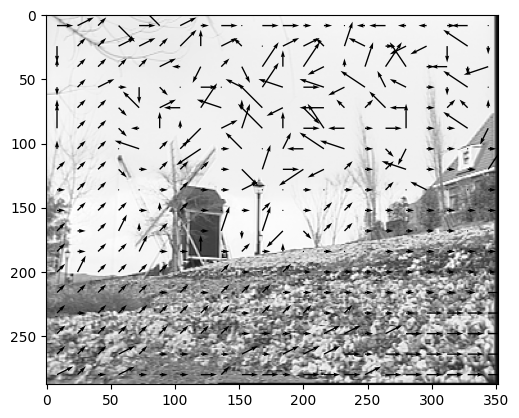

In [78]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius
displayMVF(im1,mvf_ssd,brow)

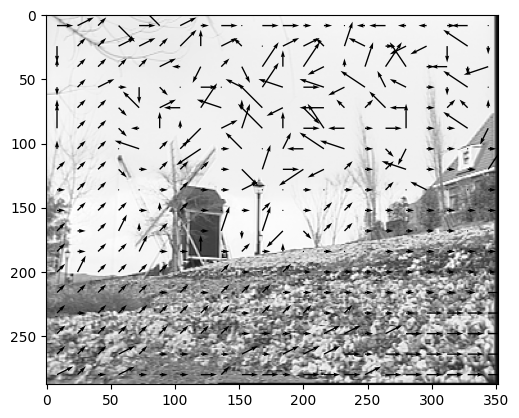

In [88]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

displayMVF(im1,mvf_ssd,brow)

- Remarks about the results:

We can clearly see that the motion field does not work well in the sky. This is due to the fact that this region is homogeneous, and therefore the algorithm cannot find the block in the following frame that best matches the one from the initial frame.

- Changing the block size and the search area radius:

As expected, decreasing the values of brow and bcol increase the resolution of the field. This tends to yield better results, however is more computationally expensive.
Changing the search radious did not change the results significantly, only in the sky, where multiple motion vectors changed and some got larger. Although at first glance it seems unexpected, as one could think that increasing the searching radious would yield better results at the cost of being more computationaly expensive, outside the sky, the ideal motion vectors appear to converge to smaller ones.

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

In [86]:
def fracMc(ref,mvf,outofbound=20):

    [rows, cols] = np.shape(ref);



    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates

    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement

    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image

    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)

    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points


    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])

    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])


    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)

    motcomp =  griddata(points, values, points_inter,'linear')

    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x780890a40a50>)

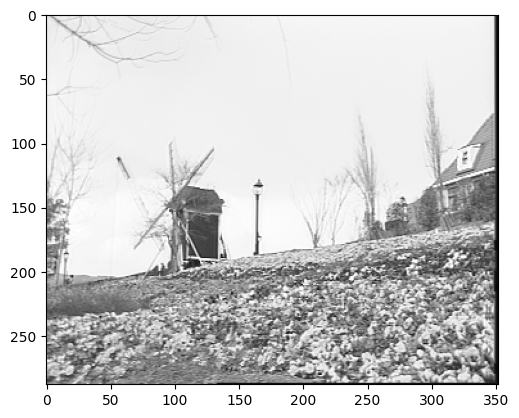

In [89]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

The resulting motion-compensated image seems satisfactory. However, we can see that some areas, especially those with more detail such as some flowered regions, are not well defined.

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

In [62]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    psnr =  20 * np.log10(np.max(im1) / np.sqrt(np.mean((im1 - im2) ** 2)))
    return psnr

In [63]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

23.189885896185892


In [90]:
psnr_im1 = PSNR(im2,im1)
print(psnr_im1)

18.786509322935075


The formula for the PSNR is:
$PSNR = \frac{MAX^2}{MSE}$

We can see that the PSNR between im2 and mc_ssd increased when compared to im1. This means that the motion compensation worked well, as the Mean Square Ratio got lower.

### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [91]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)

    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]

    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]

    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]

        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]

        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)

    pV = pV.ravel()

    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """


    step = 8
    cont = 4*step

    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV=np.zeros(2)

    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC


    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)

    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    # Non-regularized search
    if lamb == 0.:
        for r in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow,c:c+brow] # Block

                # Initialization:

                costMin = np.inf

                Rbest = np.zeros(B.shape)

                # Loop on candidate displacement vectors
                for dcol in range(c-search,c+search): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search,r+search): # rcol = candidate displacement vector over the rows
                        Bref = ref_extended[drow + search:drow + brow + search,dcol + search:dcol + bcol + search]
                        SAD_cost = np.sum(np.abs(B - Bref))
                        if SAD_cost  < costMin: # Save the results if they are better than the previous ones
                            Rbest = Bref
                            best_drow, best_dcol = drow, dcol
                            costMin = SAD_cost

                mvf[r:r+brow, c:c+bcol, 0] = r - best_drow # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 1] = c - best_dcol # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest

    else: # Regularized search
        for r in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol]# Block

                # Initializations
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)

                # Loop on candidate vectors
                for dcol in range(c-search,c+search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search, r+search+1): # rcol = candidate displacement vector over the rows
                        Bref = ref_extended[drow + search : drow + brow + search,dcol + search : dcol + bcol + search]
                        cost = (np.sum(np.abs(B - Bref)) + lamb * np.linalg.norm(np.array([drow, dcol]) - pV) ** 2) # here, encore the REGULARIZED cost function
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = Bref
                            best_drow = drow
                            best_dcol = dcol


                mvf[r:r+brow,c:c+bcol,0]= r - best_drow # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= c - best_dcol # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest


    mvf = -mvf # For compatibility with standards

    return mvf, prediction

In [92]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

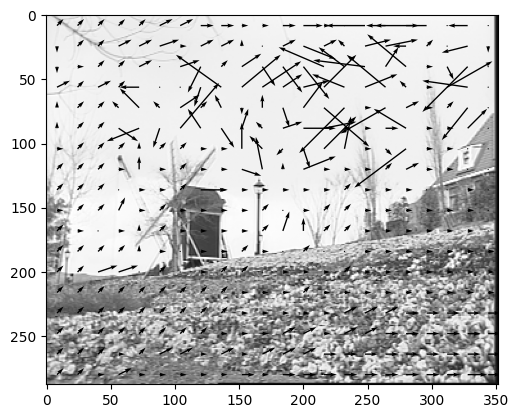

In [93]:
displayMVF(im1,mvf_sad,brow)

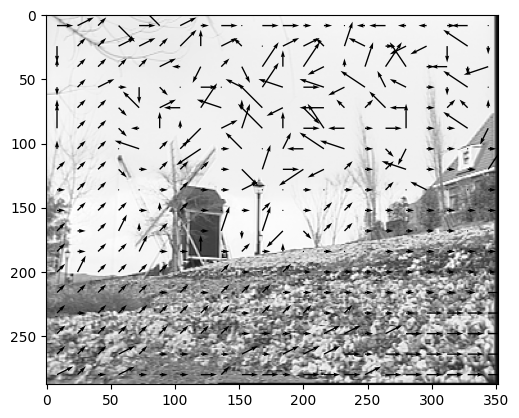

In [94]:
displayMVF(im1,mvf_ssd,brow)

The vector fields generated from both methods are simmilar, with most of the difference being in the sky, where the SAD resulted in some greater motion vectors.

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

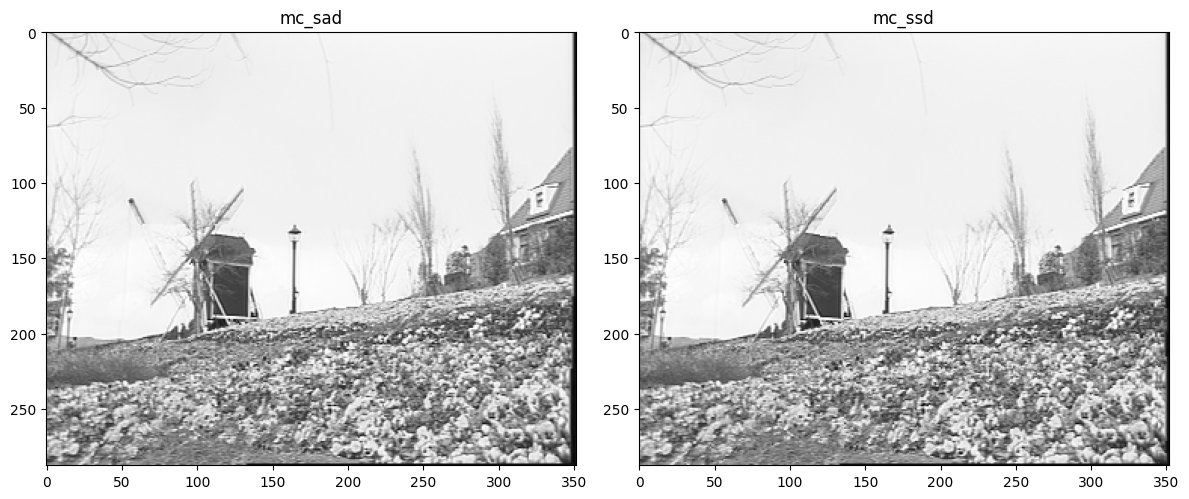

In [99]:
mc_sad = fracMc(im1, mvf_sad)
mc_ssd = fracMc(im1, mvf_ssd)

# Plot mc_sad
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mc_sad, cmap='gray')
plt.title('mc_sad')

# Plot mc_ssd
plt.subplot(1, 2, 2)
plt.imshow(mc_ssd, cmap='gray')
plt.title('mc_ssd')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [69]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

23.13260589512621


In [97]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

23.189885896185892


As previously stated, both cost functions yield simmilar results. This can be seen as the PSNR are extremely similar.

## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

PSNR for lambda = 0.00010 : 22.7058948455202
PSNR for lambda = 0.00042 : 22.70558307552742
PSNR for lambda = 0.00178 : 22.70354336469511
PSNR for lambda = 0.00750 : 22.698017051044886
PSNR for lambda = 0.03162 : 22.65454322269868
PSNR for lambda = 0.13335 : 22.389625535991033
PSNR for lambda = 0.56234 : 18.50090546028715
PSNR for lambda = 2.37137 : 14.264775696229169
PSNR for lambda = 10.00000 : 13.94203224451534


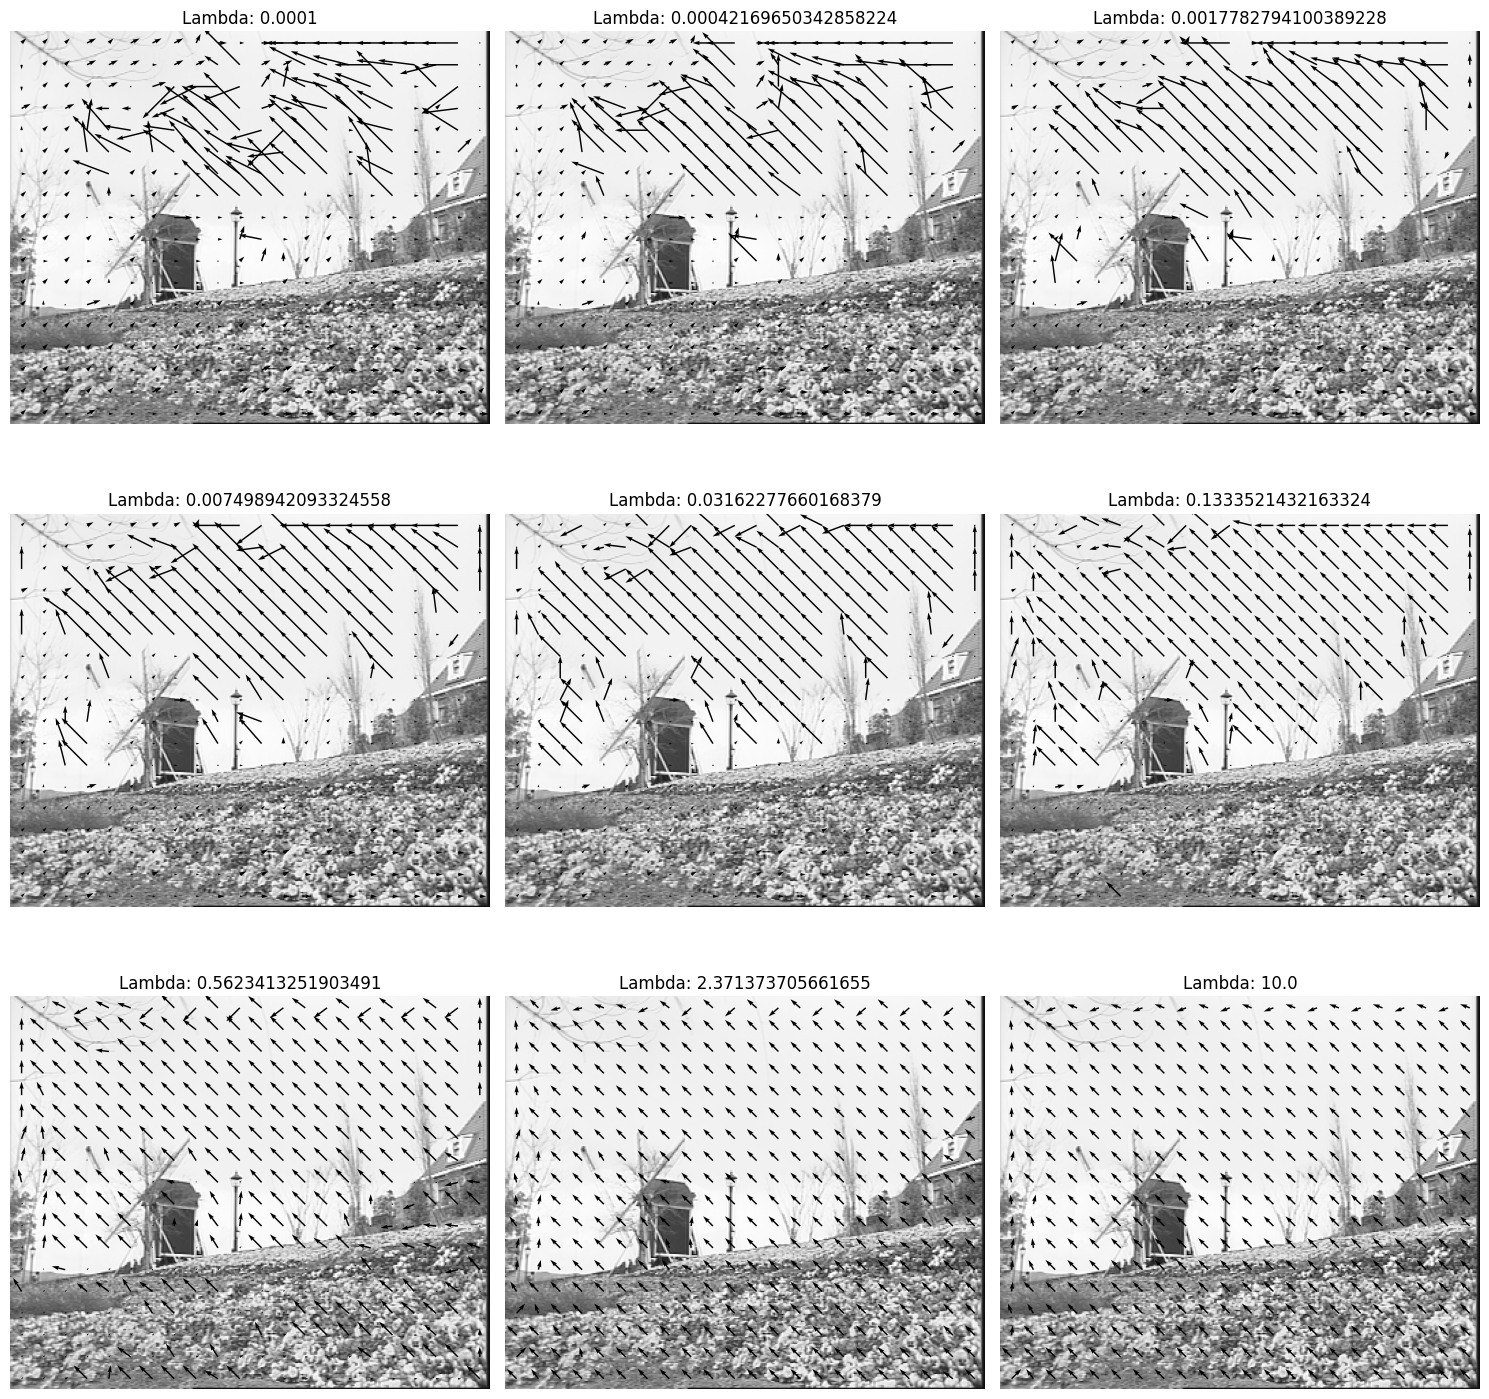

In [105]:
lambdas = np.logspace(-4, 1, 9)
fig, axs = plt.subplots(len(lambdas)//3, 3, figsize=(15, 15))


brow = 16
bcol = 16
search_radius = 8

row, col = np.shape(im1)
mvf_ssds = []
for i, lamb in enumerate(lambdas):
    mvf_ssd_reg, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb=lamb)
    mc_ssd_reg = fracMc(im1, mvf_ssd_reg)
    psnr_ssd_reg = PSNR(im2, mc_ssd_reg)
    print(f"PSNR for lambda = {lamb:.5f} : {psnr_ssd_reg}")
    mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb)
    vectRow = mvf_ssd[0:row:brow, 0:col:brow, 0]
    vectCol = mvf_ssd[0:row:brow, 0:col:brow, 1]

    X, Y = np.meshgrid(np.arange(0, im1.shape[1], brow), np.arange(0, im1.shape[0], brow))
    X = X + np.floor(brow / 2.)
    Y = Y + np.floor(brow / 2.)

    axs[i // 3, i % 3].imshow(im1, cmap='gray')
    axs[i // 3, i % 3].quiver(X, Y, vectCol, -vectRow)
    axs[i // 3, i % 3].set_title(f"Lambda: {lamb}")
    axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

Surprisingly, the PSNR monotonically decreases as lambda increases, and therefore lambda = 0 yields the best result.

### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

PSNR for lambda = 0.00010 : 22.61420978871733
PSNR for lambda = 0.00042 : 22.606719502705424
PSNR for lambda = 0.00178 : 22.428612252817
PSNR for lambda = 0.00750 : 15.325528962590854
PSNR for lambda = 0.03162 : 14.00590926834992
PSNR for lambda = 0.13335 : 13.94070620028424
PSNR for lambda = 0.56234 : 13.911197560074422
PSNR for lambda = 2.37137 : 13.895727053142906
PSNR for lambda = 10.00000 : 13.879838399353071


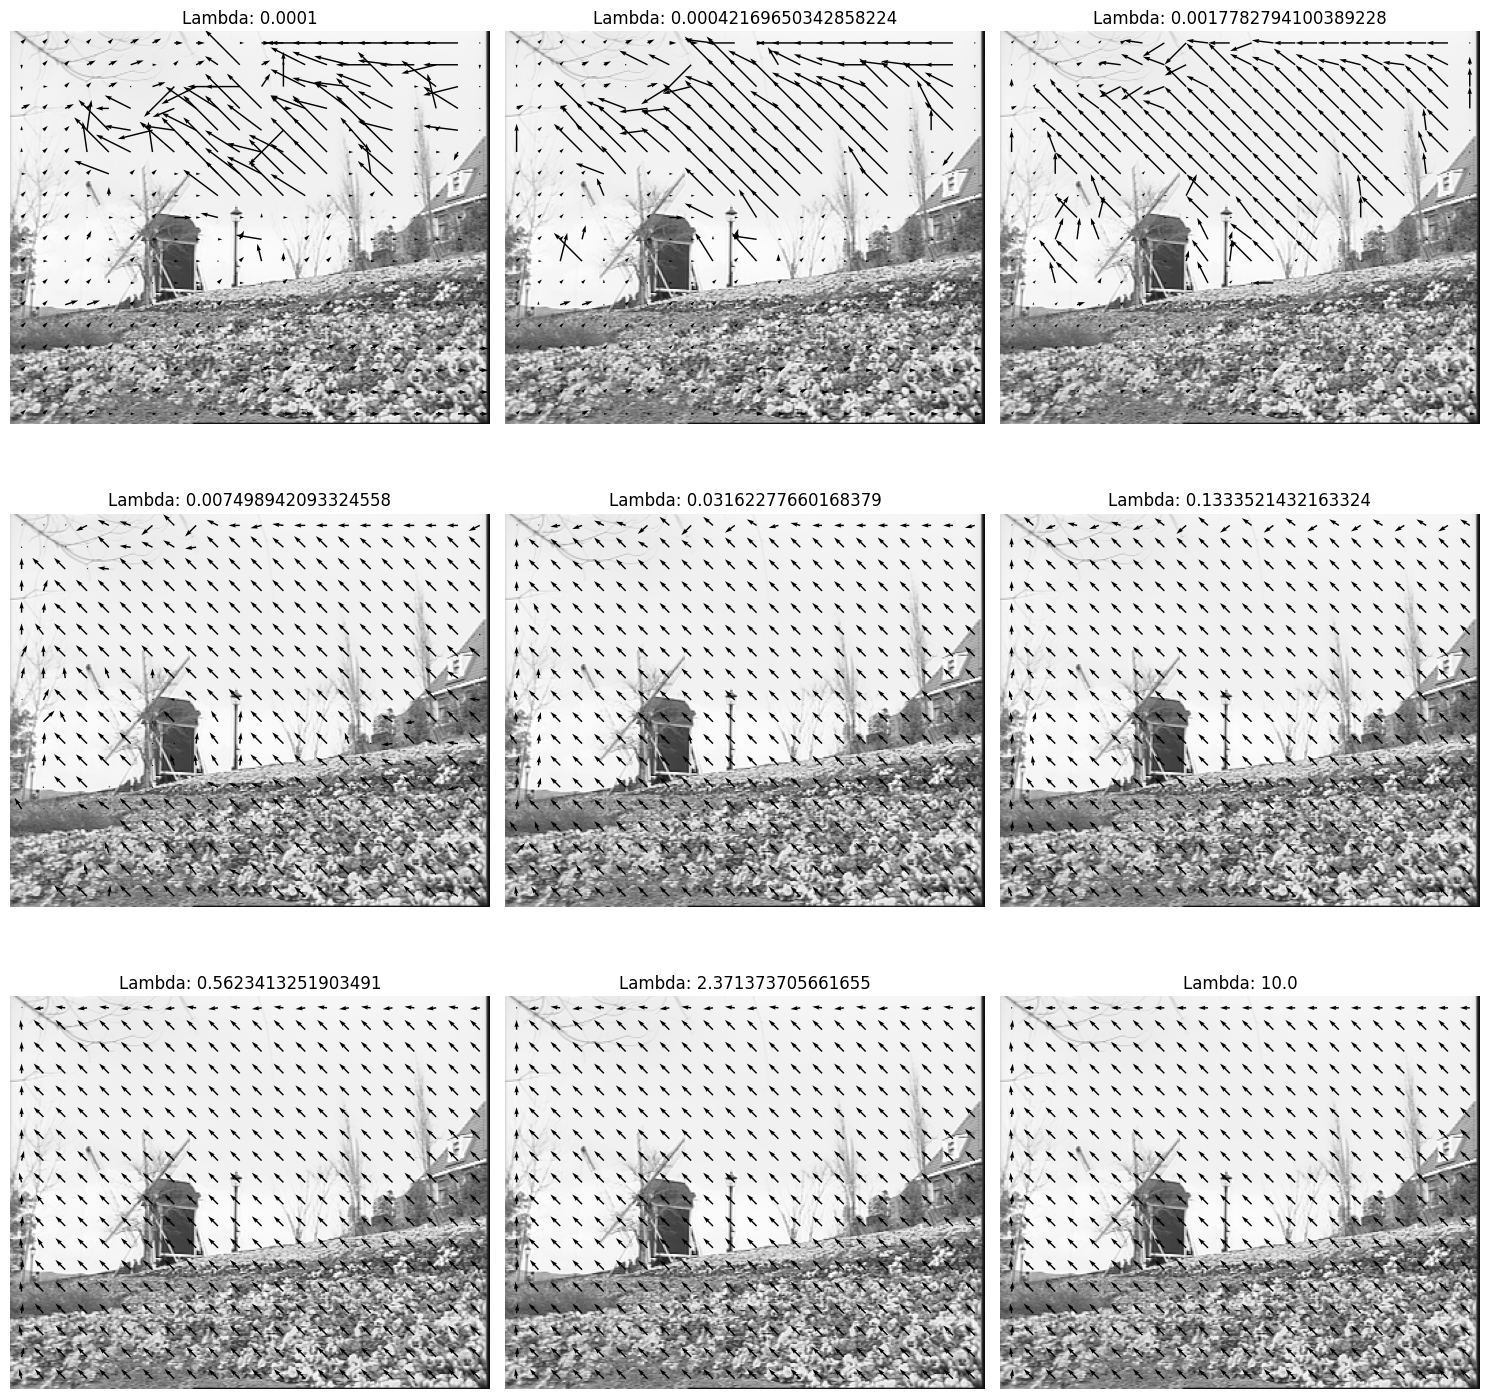

In [107]:
lambdas = np.logspace(-4, 1, 9)
fig, axs = plt.subplots(len(lambdas)//3, 3, figsize=(15, 15))


brow = 16
bcol = 16
search_radius = 8

row, col = np.shape(im1)
mvf_ssds = []
for i, lamb in enumerate(lambdas):
    mvf_sad_reg, prediction = me_sad(im2, im1, brow, bcol, search_radius, lamb=lamb)
    mc_sad_reg = fracMc(im1, mvf_sad_reg)
    psnr_sad_reg = PSNR(im2, mc_sad_reg)
    print(f"PSNR for lambda = {lamb:.5f} : {psnr_sad_reg}")
    mvf_sad, prediction = me_sad(im2, im1, brow, bcol, search_radius, lamb)
    vectRow = mvf_sad[0:row:brow, 0:col:brow, 0]
    vectCol = mvf_sad[0:row:brow, 0:col:brow, 1]

    X, Y = np.meshgrid(np.arange(0, im1.shape[1], brow), np.arange(0, im1.shape[0], brow))
    X = X + np.floor(brow / 2.)
    Y = Y + np.floor(brow / 2.)

    axs[i // 3, i % 3].imshow(im1, cmap='gray')
    axs[i // 3, i % 3].quiver(X, Y, vectCol, -vectRow)
    axs[i // 3, i % 3].set_title(f"Lambda: {lamb}")
    axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

Surprisingly, the PSNR monotonically decreases as lambda increases, and therefore lambda = 0 yields the best result.

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [108]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x780890f29410>)

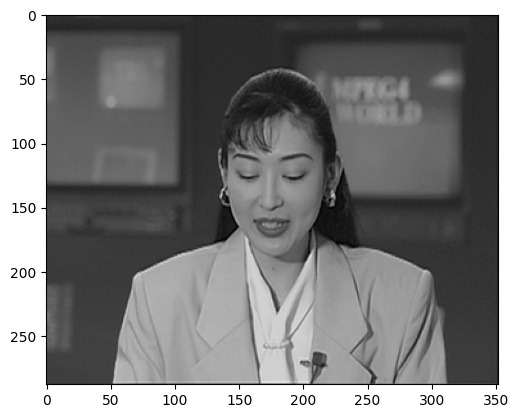

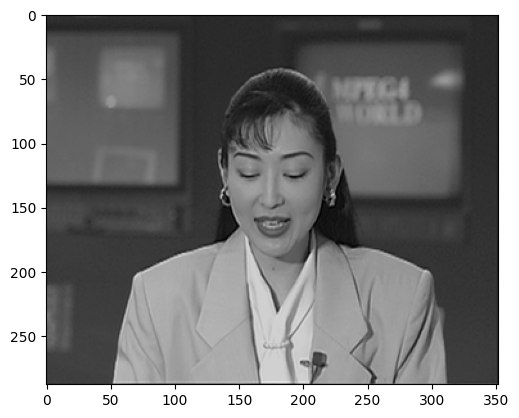

In [109]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

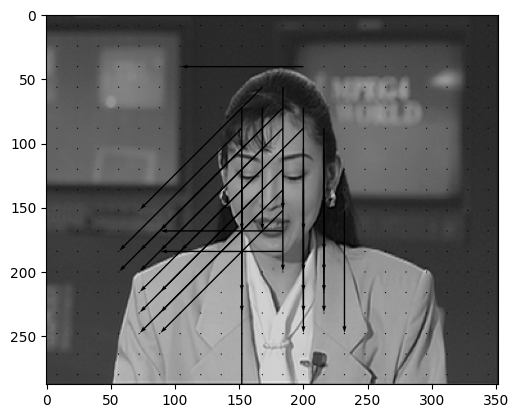

In [120]:
brow = 16; bcol=16; search_radius =13;

mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius)
displayMVF(im1, mvf_ssd, brow)

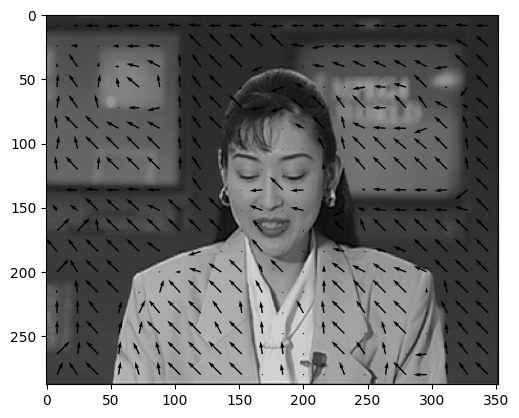

In [123]:
mvf_ssd_01, prediction = me_ssd(im2, im1, brow, bcol, search_radius,lamb=0.1)
displayMVF(im1, mvf_ssd_01, brow)

In [124]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337

    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)

    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """

    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)

    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()

    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)

    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])

    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg= convolve2d(u, kernel_1)[1:-1, 1:-1]
        vAvg= convolve2d(v, kernel_1)[1:-1, 1:-1]

        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx * (uAvg * fx + vAvg * fy + ft) / (alpha**2 + np.linalg.norm(fx + fy + ft) ** 2)
        v = vAvg - fx * (uAvg * fx + vAvg * fy + ft) / (alpha**2 + np.linalg.norm(fx + fy + ft) ** 2)

    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [125]:
alpha = 100
ite = 100

uInitial = mvf_ssd[:, :, 0] # Rem: pay attention to the inversion of the order compared to me_ssd.
vInitial = mvf_ssd[:, :, 1]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

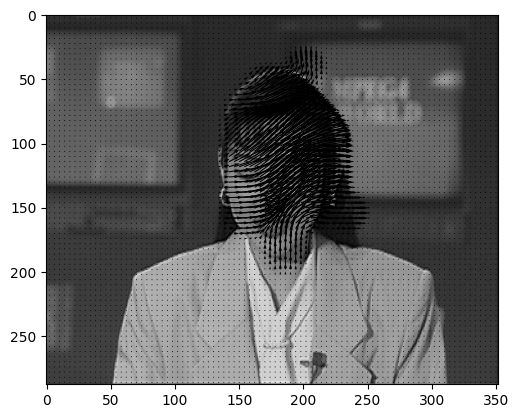

In [126]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [127]:
psnr_hs

32.445654880705945

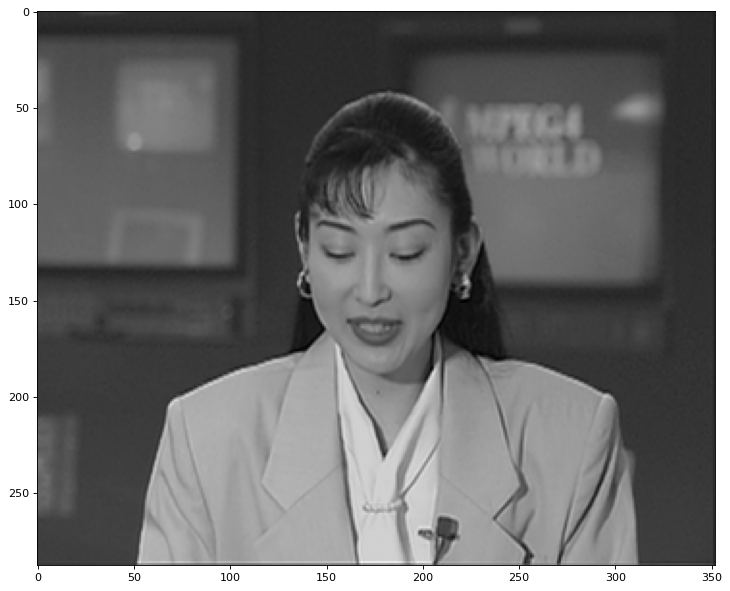

In [128]:
mc_hs = fracMc(im1, mvf_hs)

plt.figure(figsize=(16, 9), dpi=80)
plt.imshow(mc_hs, cmap="gray")
plt.show()

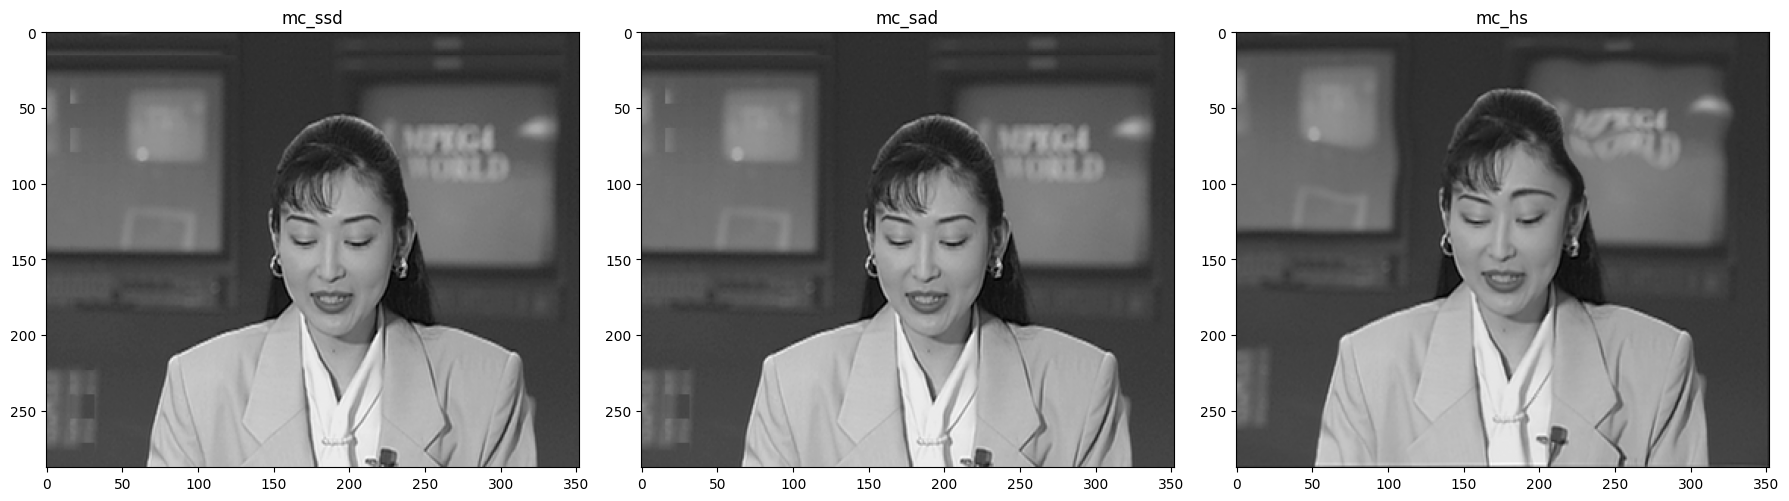

In [148]:
mvf_ssd, prediction = me_sad(im2, im1, brow, bcol, search_radius, lamb)
mvf_sad, prediction = me_sad(im2, im1, brow, bcol, search_radius, lamb)
mc_ssd = fracMc(im1, mvf_ssd)
mc_sad = fracMc(im1, mvf_sad)
mc_hs  = fracMc(im1, mvf_hs)

# Plot mc_sad, mc_ssd, and mc_hs side by side
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(mc_ssd, cmap='gray')
plt.title('mc_ssd')

plt.subplot(1, 3, 2)
plt.imshow(mc_sad, cmap='gray')
plt.title('mc_sad')

plt.subplot(1, 3, 3)
plt.imshow(mc_hs, cmap='gray')
plt.title('mc_hs')

plt.tight_layout()
plt.show()


In [149]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

psnr_hs = PSNR(im2,mc_hs)
print(psnr_hs)


17.035454500426393
17.035454500426393
27.886226493196986


Now with the flower image

In [152]:
im1_flower = loadmat('flower_cif_1.mat')['im1']
im1_flower = im1_flower.astype('float')
im2_flower = loadmat('flower_cif_2.mat')['im2']
im2_flower = im2_flower.astype('float')

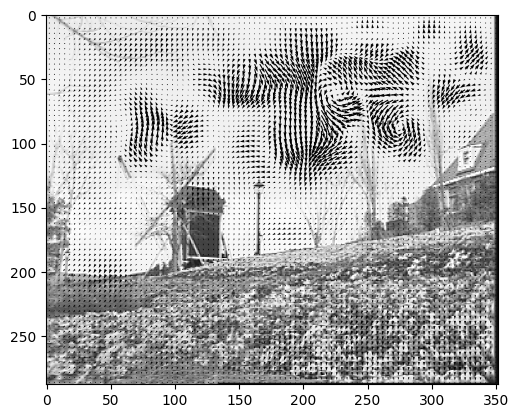

In [153]:
alpha = 100
ite = 100


mvf, _ = me_sad(im2_flower, im1_flower, brow, bcol, search_radius)

uInitial = mvf[:, :, 0] # Rem: pay attention to the inversion of the order compared to me_ssd.
vInitial = mvf[:, :, 1]
[u, v] = HS(im2_flower, im1_flower, uInitial, vInitial, alpha, ite,blur=1.)

mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1_flower,mvf_hs,4)

mc_hs = fracMc(im1_flower,mvf_hs)
psnr_hs = PSNR(im2_flower,mc_hs)

We can see that the motion vectors in the sky are much smaller.

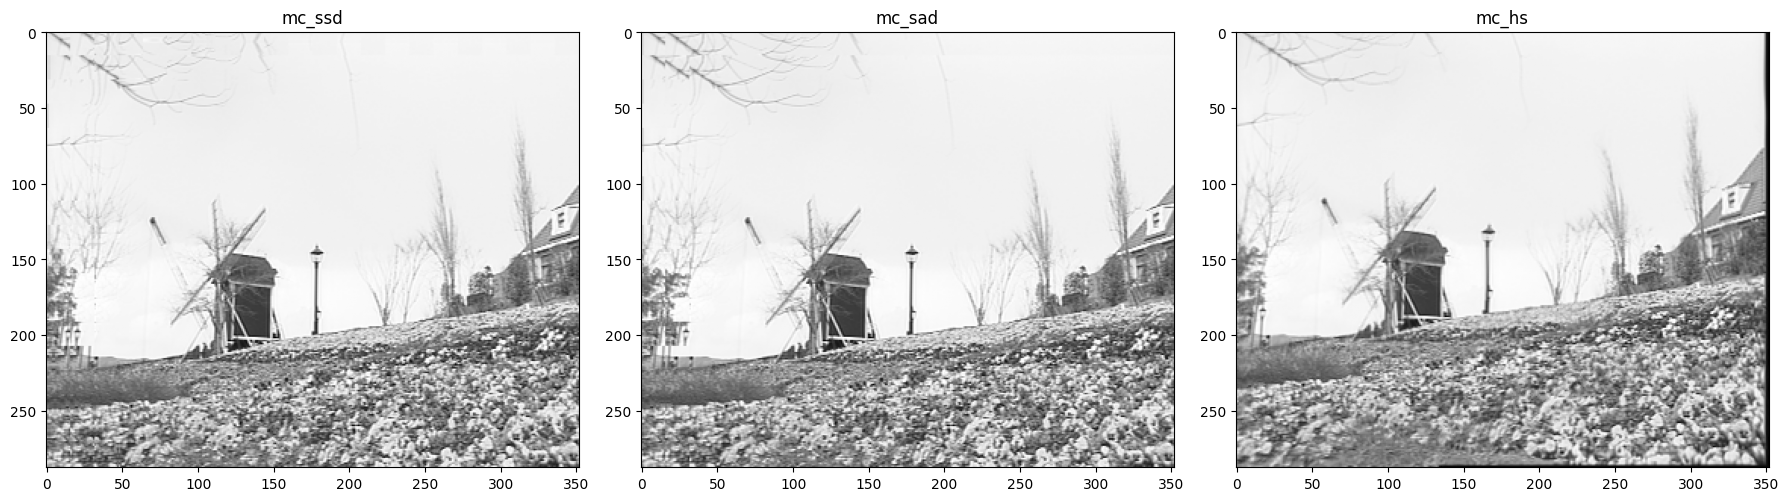

In [156]:
mvf_ssd_f, prediction = me_ssd(im2_flower, im1_flower, brow, bcol, search_radius, lamb)
mvf_sad_f, prediction = me_sad(im2_flower, im1_flower, brow, bcol, search_radius, lamb)
mc_ssd_f = fracMc(im1_flower, mvf_ssd_f)
mc_sad_f = fracMc(im1_flower, mvf_sad_f)
mc_hs_f  = fracMc(im1_flower, mvf_hs)

# Plot mc_sad, mc_ssd, and mc_hs side by side
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(mc_ssd_f, cmap='gray')
plt.title('mc_ssd')

plt.subplot(1, 3, 2)
plt.imshow(mc_sad_f, cmap='gray')
plt.title('mc_sad')

plt.subplot(1, 3, 3)
plt.imshow(mc_hs_f, cmap='gray')
plt.title('mc_hs')

plt.tight_layout()
plt.show()


In [157]:
psnr_ssd = PSNR(im2_flower,mc_ssd_f)
print(psnr_ssd)

psnr_sad = PSNR(im2_flower,mc_sad_f)
print(psnr_sad)

psnr_hs = PSNR(im2_flower,mc_hs_f)
print(psnr_hs)


13.49499419302429
13.407225292322218
16.822297570300297


For both images we can see that the Horn and Schunck algorithm yielded much better results.